## Library

In [1]:
import os
import vtk
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages  # 引入PDF保存模块
from scipy.signal import find_peaks
import pyvista as pv  

## 1 Brava中心线相关信息(ICA全长)

### 1.1 中心线长度信息

Total number of centerline files: 79
Minimum centerline length: 59.22610621769467
Maximum centerline length: 98.56068770545313
Average centerline length: 75.07954866493863


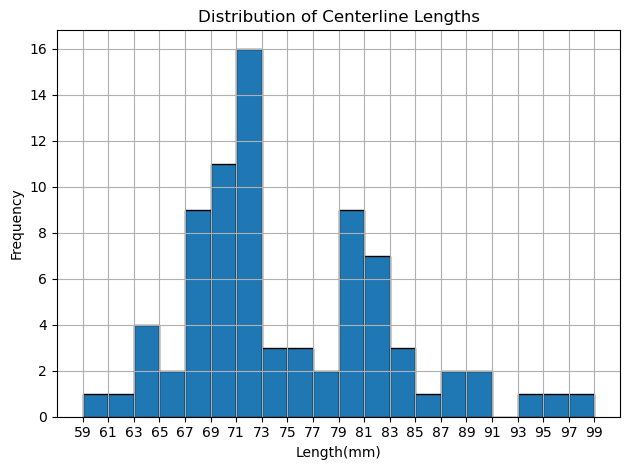

In [2]:
# 目录路径（输入）2_Original(from feng) 的路径
vtk_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\2_Original(from feng)" #修改为你的路径
vtk_files = [f for f in os.listdir(vtk_dir) if f.endswith(".vtk")]

def compute_length_from_vtk(file_path):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(file_path)
    reader.Update()
    polydata = reader.GetOutput()
    points = polydata.GetPoints()
    lines = polydata.GetLines()
    lines.InitTraversal()
    id_list = vtk.vtkIdList()
    total_length = 0.0

    while lines.GetNextCell(id_list):
        for i in range(id_list.GetNumberOfIds() - 1):
            pt1 = np.array(points.GetPoint(id_list.GetId(i)))
            pt2 = np.array(points.GetPoint(id_list.GetId(i + 1)))
            total_length += np.linalg.norm(pt2 - pt1)
    return total_length

lengths = []

for file in vtk_files:
    file_path = os.path.join(vtk_dir, file)
    length = compute_length_from_vtk(file_path)
    lengths.append(length)

# 打印统计信息
print("Total number of centerline files:", len(lengths))
print("Minimum centerline length:", np.min(lengths))
print("Maximum centerline length:", np.max(lengths))
print("Average centerline length:", np.mean(lengths))

# -----------------------------
# 绘图部分：横轴整数间隔，边界对齐
min_val = int(np.floor(np.min(lengths)))
max_val = int(np.ceil(np.max(lengths)))
step = 2  # 你可以根据需要修改为 2 或 10

bins = np.arange(min_val, max_val + step, step)

counts, bins, patches = plt.hist(lengths, bins=bins, edgecolor='black', rwidth=1.0)
plt.xticks(bins)  # 横轴刻度与柱子边界对齐

plt.title("Distribution of Centerline Lengths")
plt.xlabel("Length(mm)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


### 1.2 中心线点间距信息（不等距）

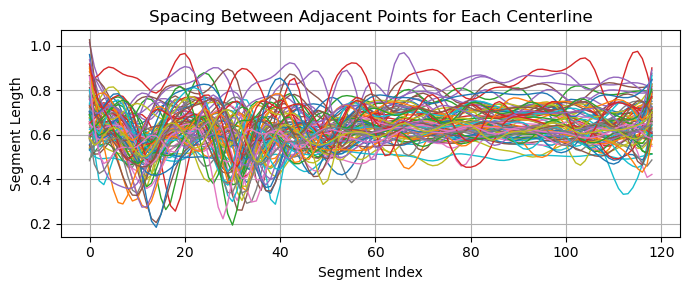

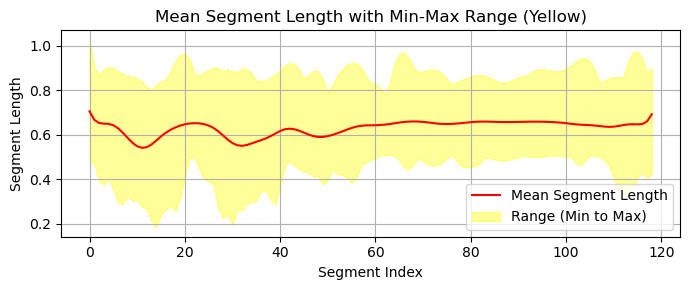

In [3]:
# 目录路径（输入）2_Original(from feng) 的路径
vtk_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\2_Original(from feng)" #修改为你的路径
vtk_files = glob.glob(os.path.join(vtk_dir, "*.vtk"))

# 存储每条中心线的点间距数据
segment_data = {}

for file_path in vtk_files:
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(file_path)
    reader.Update()
    polydata = reader.GetOutput()
    points = polydata.GetPoints()
    if not points or points.GetNumberOfPoints() < 2:
        continue

    distances = []
    for i in range(points.GetNumberOfPoints() - 1):
        p1 = np.array(points.GetPoint(i))
        p2 = np.array(points.GetPoint(i + 1))
        d = np.linalg.norm(p2 - p1)
        distances.append(d)

    name = os.path.basename(file_path).replace(".vtk", "")
    segment_data[name] = distances

# 第一张图：每条中心线的 segment length 曲线
plt.figure(figsize=(7, 3))
for name, dists in segment_data.items():
    plt.plot(range(len(dists)), dists, label=name, linewidth=1)

plt.xlabel("Segment Index")
plt.ylabel("Segment Length")
plt.title("Spacing Between Adjacent Points for Each Centerline")
plt.grid(True)
plt.tight_layout()
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="x-small")
plt.show()

# 第二张图：平均值 + min-max 区间（黄色）
# 仅保留长度一致的中心线
max_len = max(len(v) for v in segment_data.values())
valid_lines = [v for v in segment_data.values() if len(v) == max_len]
arr = np.array(valid_lines)

mean_d = np.mean(arr, axis=0)
min_d = np.min(arr, axis=0)
max_d = np.max(arr, axis=0)

# 可视化：黄色区域表示 max-min 区间
plt.figure(figsize=(7, 3))
plt.plot(range(max_len), mean_d, color='red', label='Mean Segment Length')
plt.fill_between(range(max_len), min_d, max_d,
                 color='yellow', alpha=0.4, label='Range (Min to Max)')

plt.xlabel("Segment Index")
plt.ylabel("Segment Length")
plt.title("Mean Segment Length with Min-Max Range (Yellow)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 2 Brava中心线前处理

### 2.1 中心线出口入口延长
批量读取中心线（centerline）的 VTK 文件，延长两端并重采样成固定数量的点（例如 300 点），再输出为新的 VTK 文件。

- 入口方向延长约 12 mm
- 出口方向延长约 22 mm

In [4]:
def interpolate_polyline_fixed(points, fixed_n=300):
    distances = np.linalg.norm(np.diff(points, axis=0), axis=1)
    cum_dist = np.insert(np.cumsum(distances), 0, 0)
    total_length = cum_dist[-1]
    target_d = np.linspace(0, total_length, fixed_n)

    interpolated = []
    j = 0
    for d in target_d:
        while j < len(cum_dist) - 2 and d > cum_dist[j + 1]:
            j += 1
        t = (d - cum_dist[j]) / (cum_dist[j+1] - cum_dist[j])
        p = (1 - t) * points[j] + t * points[j + 1]
        interpolated.append(p)
    return np.array(interpolated)

def extend_and_resample_to_fixed_ascii(input_path, output_path, extend_entry=12, extend_exit=22, fixed_n=300, spacing=0.6):
    # 读取 ASCII VTK 中心线文件（Legacy）
    with open(input_path, 'r') as f:
        lines = f.readlines()

    # 找到 POINTS 和 LINES 起始行
    points_start = [i for i, line in enumerate(lines) if line.startswith("POINTS")][0]
    lines_start = [i for i, line in enumerate(lines) if line.startswith("LINES")][0]

    num_points = int(lines[points_start].split()[1])
    point_lines = lines[points_start + 1 : lines_start]
    points = np.array([float(x) for line in point_lines for x in line.strip().split()]).reshape(-1, 3)

    # 延长入口和出口
    entry_dir = points[1] - points[0]
    entry_dir /= np.linalg.norm(entry_dir)
    exit_dir = points[-1] - points[-2]
    exit_dir /= np.linalg.norm(exit_dir)

    n_entry = int(extend_entry / spacing)
    n_exit = int(extend_exit / spacing)

    entry_ext = [points[0] - i * spacing * entry_dir for i in range(n_entry, 0, -1)]
    exit_ext = [points[-1] + i * spacing * exit_dir for i in range(1, n_exit + 1)]

    extended_coords = np.vstack([entry_ext, points, exit_ext])

    # 重采样为固定点数
    resampled = interpolate_polyline_fixed(extended_coords, fixed_n)

    # 写入 ASCII VTK（Legacy）
    with open(output_path, 'w') as f:
        # 头部复制
        for i in range(points_start):
            f.write(lines[i])

        # 写 POINTS
        f.write(f"POINTS {fixed_n} float\n")
        for pt in resampled:
            f.write(f"{pt[0]} {pt[1]} {pt[2]}\n")

        # 写 LINES
        f.write(f"LINES 1 {fixed_n + 1}\n")
        f.write(f"{fixed_n} " + ' '.join(str(i) for i in range(fixed_n)) + '\n')

    # print(f"[OK] {os.path.basename(input_path)} → {os.path.basename(output_path)} | {fixed_n} points")

# 批量处理路径
input_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\2_Original(from feng)" # 修改为你的输入路径
output_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\3_Centerline(extension 300)" # 修改为你的输出路径
os.makedirs(output_dir, exist_ok=True)

files = [f for f in os.listdir(input_dir) if f.endswith(".vtk")]
# print(f"Found {len(files)} files.\n")

for fname in files:
    in_path = os.path.join(input_dir, fname)
    out_path = os.path.join(output_dir, fname)
    extend_and_resample_to_fixed_ascii(in_path, out_path)


### 2.2 增加中心线半径(1mm)

In [7]:
# 目录路径
input_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\3_Centerline(extension 300)" # 修改为你的输入路径
output_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\4_Centerline(extension 300 R1)" # 修改为你的输出路径

# 确保输出目录存在
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 获取所有 VTK 文件
vtk_files = [f for f in os.listdir(input_dir) if f.endswith(".vtk")]

for file_name in vtk_files:
    input_file = os.path.join(input_dir, file_name)
    output_file = os.path.join(output_dir, file_name)  # 保持原文件名

    # 读取原始文件内容
    with open(input_file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    # 查找 POINTS 行，提取点的数量
    num_points = None
    for line in lines:
        if line.strip().startswith("POINTS"):
            num_points = int(line.split()[1])
            break

    if num_points is None:
        print(f"⚠️ 未能找到 POINTS 定义，跳过文件: {file_name}")
        continue

    # 生成新的 POINT_DATA 部分
    radius_section = [
        f"\nPOINT_DATA {num_points}\n",
        "SCALARS MaximumInscribedSphereRadius float\n",
        "LOOKUP_TABLE default\n",
    ] + [f"1\n" for _ in range(num_points)]

    # 将新的数据追加到原始内容
    with open(output_file, "w", encoding="utf-8") as f:
        f.writelines(lines)  # 写入原始内容
        f.writelines(radius_section)  # 追加新的数据部分

    #print(f"✅ 处理完成: {file_name}")

#print(f"\n🎉 所有 VTK 文件已成功添加半径，并保存到: {output_dir}")


## 3 vmtk批处理（batch）

In [8]:
# 输入和输出文件夹路径
input_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\4_Centerline(extension 300 R1)"
output_dir = r"D:\github\Phd_summary\1_Data\1_Brava\2_stl\1_model_R1(from vmtk)"
output_script = r"D:\github\Phd_summary\1_Data\1_Brava\3_vmtk\vmtk_batch_commands_300_r2(256).txt"

# 确保输出目录存在
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 获取所有 .vtk 文件
vtk_files = [f for f in os.listdir(input_dir) if f.endswith(".vtk")]

# VMTK 处理参数
dimensions = "256 256 256"

# 生成 VMTK 命令
commands = []
for file_name in vtk_files:
    input_file = os.path.join(input_dir, file_name).replace("\\", "/")  # 转换为 VMTK 兼容路径
    output_file = os.path.join(output_dir, file_name.replace(".vtk", "_tube.stl")).replace("\\", "/")

    command = f'vmtkcenterlinemodeller -ifile "{input_file}" -radiusarray MaximumInscribedSphereRadius -dimensions {dimensions} --pipe vmtkmarchingcubes -ofile "{output_file}"'
    commands.append(command)

# 将命令写入 TXT 文件
with open(output_script, "w", encoding="utf-8") as f:
    f.write("\n".join(commands))

#print(f"✅ VMTK 批量命令已生成，保存至: {output_script}")
#print("📋 请打开 TXT 文件，复制命令并粘贴到 VMTK 终端运行！")


## 4 网格变形用（txt文件）

In [9]:
def vtk_to_txt(vtk_file_path, txt_file_path):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(vtk_file_path)
    reader.Update()
    polydata = reader.GetOutput()

    points = polydata.GetPoints()
    num_points = points.GetNumberOfPoints()

    with open(txt_file_path, 'w', encoding='utf-8') as f:
        f.write(f"#pt3d {num_points}\n")
        for i in range(num_points):
            x, y, z = points.GetPoint(i)
            f.write(f"{x:.6f} {y:.6f} {z:.6f}\n")

def batch_convert_vtk_to_txt(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(".vtk"):
            vtk_path = os.path.join(input_dir, filename)
            txt_filename = os.path.splitext(filename)[0] + ".txt"
            txt_path = os.path.join(output_dir, txt_filename)
            #print(f"Converting: {vtk_path} -> {txt_path}")
            vtk_to_txt(vtk_path, txt_path)

# 指定输入输出路径
input_directory = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\4_Centerline(extension 300 R1)"
output_directory = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\5_Centerline(Mesh deformation 300 R1 txt)"

batch_convert_vtk_to_txt(input_directory, output_directory)


## 5 曲率和扭率

### 5.1 曲率扭率可视化(V-modeler)

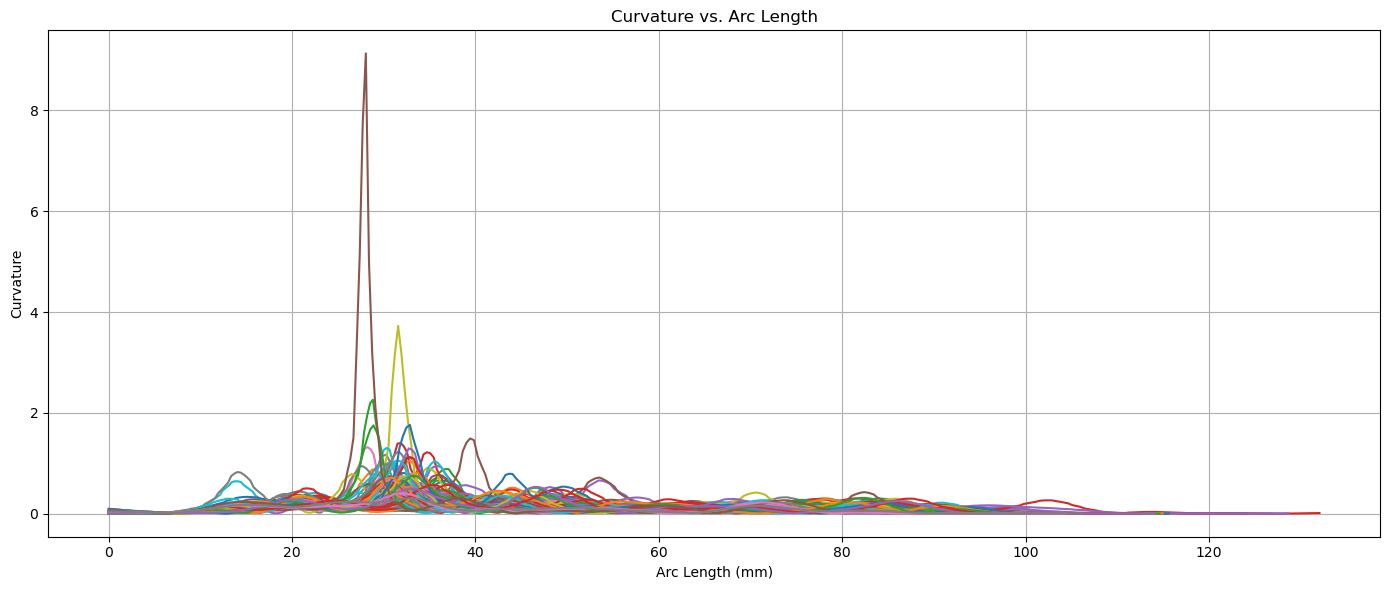

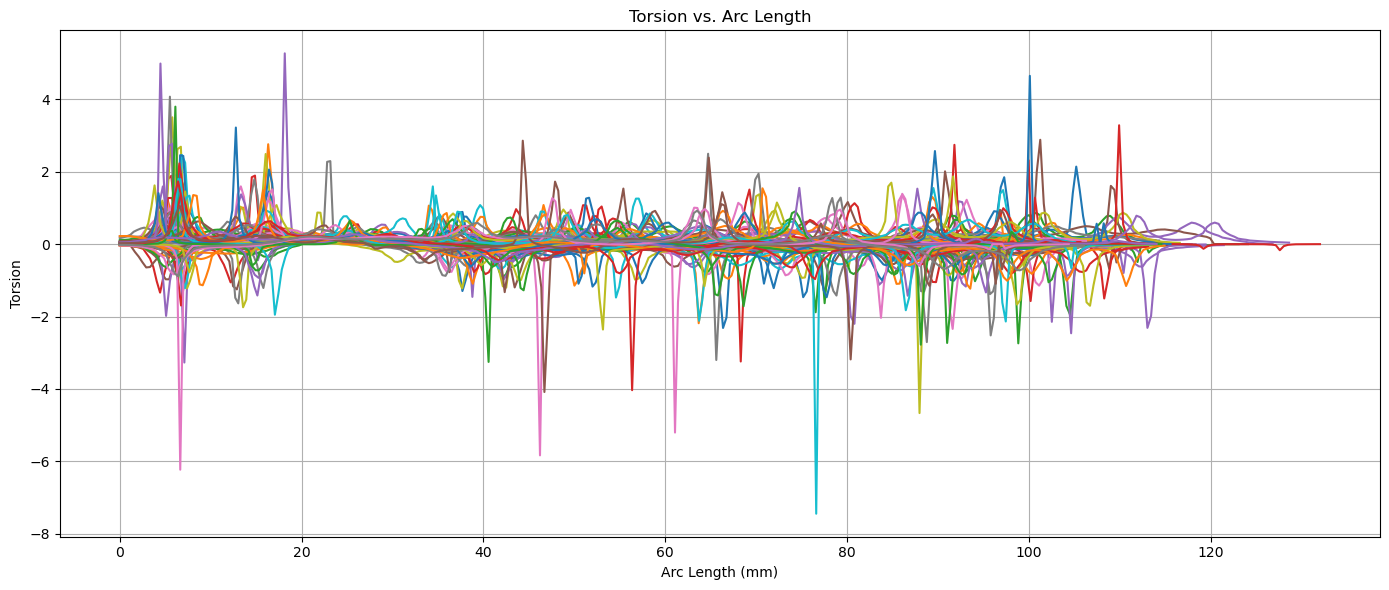

In [10]:
def load_ply_with_curvature_torsion(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    header_end_idx = next(i for i, line in enumerate(lines) if 'end_header' in line)
    vertex_count = 0
    for line in lines:
        if line.startswith("element vertex"):
            vertex_count = int(line.split()[-1])
            break

    vertex_lines = lines[header_end_idx + 1 : header_end_idx + 1 + vertex_count]
    data = [list(map(float, line.strip().split())) for line in vertex_lines]
    df = pd.DataFrame(data, columns=["x", "y", "z", "label", "attribute", "radius", "curvature", "torsion"])
    
    coords = df[["x", "y", "z"]].values
    segment_lengths = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    arc_length = np.insert(np.cumsum(segment_lengths), 0, 0.0)
    df["arc_length"] = arc_length

    return df

# 获取所有 .ply 文件
directory = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\6_Centerline(V-modeler)"
ply_files = [f for f in os.listdir(directory) if f.endswith(".ply")]

# 初始化图
plt.figure(figsize=(14, 6))
plt.subplot(1, 1, 1)
for fname in ply_files:
    df = load_ply_with_curvature_torsion(os.path.join(directory, fname))
    plt.plot(df["arc_length"], df["curvature"], label=f"{fname}")
plt.xlabel("Arc Length (mm)")
plt.ylabel("Curvature")
plt.title("Curvature vs. Arc Length")
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
for fname in ply_files:
    df = load_ply_with_curvature_torsion(os.path.join(directory, fname))
    plt.plot(df["arc_length"], df["torsion"], label=f"{fname}")
plt.xlabel("Arc Length (mm)")
plt.ylabel("Torsion")
plt.title("Torsion vs. Arc Length")
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 5.2 曲率扭率可视化保存(全体)

In [11]:
def load_ply_with_curvature_torsion(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    header_end_idx = next(i for i, line in enumerate(lines) if 'end_header' in line)
    vertex_count = 0
    for line in lines:
        if line.startswith("element vertex"):
            vertex_count = int(line.split()[-1])
            break

    vertex_lines = lines[header_end_idx + 1 : header_end_idx + 1 + vertex_count]
    data = [list(map(float, line.strip().split())) for line in vertex_lines]
    df = pd.DataFrame(data, columns=["x", "y", "z", "label", "attribute", "radius", "curvature", "torsion"])

    coords = df[["x", "y", "z"]].values
    segment_lengths = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    cumulative_length = np.insert(np.cumsum(segment_lengths), 0, 0.0)
    df["line_length"] = cumulative_length

    return df

# === 输入与输出路径 ===
directory = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\6_Centerline(V-modeler)"
output_pdf = r"D:\github\Phd_summary\3_Result\1_Brava\1_Centerline\1_Curvature and Torsion(total)\1_curvature_Torsion_total.pdf"

# 如果输出文件夹不存在就创建
os.makedirs(os.path.dirname(output_pdf), exist_ok=True)

ply_files = [f for f in os.listdir(directory) if f.endswith(".ply")]
num_files = len(ply_files)

# === 保存到指定路径的 PDF ===
with PdfPages(output_pdf) as pdf:
    fig, axes = plt.subplots(nrows=num_files, ncols=2, figsize=(14, 2.5 * num_files), sharex=False)

    if num_files == 1:
        axes = np.array([axes])

    for i, fname in enumerate(ply_files):
        df = load_ply_with_curvature_torsion(os.path.join(directory, fname))

        # 曲率
        axes[i, 0].plot(df["line_length"], df["curvature"], color='blue')
        axes[i, 0].set_title(f"{fname} - Curvature")
        axes[i, 0].set_xlabel("Centerline Length (mm)")
        axes[i, 0].set_ylabel("Curvature")
        axes[i, 0].grid(True)

        # 扭率
        axes[i, 1].plot(df["line_length"], df["torsion"], color='green')
        axes[i, 1].set_title(f"{fname} - Torsion")
        axes[i, 1].set_xlabel("Centerline Length (mm)")
        axes[i, 1].set_ylabel("Torsion")
        axes[i, 1].grid(True)

    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

#print(f"✅ 已保存所有图为 PDF 文件：{output_pdf}")


### 5.3 识别曲率峰值并剪裁siphon（一般）

In [12]:
def load_ply_with_curvature_torsion(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()
    header_end_idx = next(i for i, line in enumerate(lines) if "end_header" in line)
    vertex_count = 0
    for line in lines:
        if line.startswith("element vertex"):
            vertex_count = int(line.split()[-1])
            break
    vertex_lines = lines[header_end_idx + 1 : header_end_idx + 1 + vertex_count]
    data = [list(map(float, line.strip().split())) for line in vertex_lines]
    df = pd.DataFrame(data, columns=["x", "y", "z", "label", "attribute", "radius", "curvature", "torsion"])
    coords = df[["x", "y", "z"]].values
    segment_lengths = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    cumulative_length = np.insert(np.cumsum(segment_lengths), 0, 0.0)
    df["centerline_length"] = cumulative_length
    return df

def analyze_ply_for_subplot(filepath):
    df = load_ply_with_curvature_torsion(filepath)
    curvatures = df["curvature"].values
    torsions = df["torsion"].values
    lengths = df["centerline_length"].values
    peaks, _ = find_peaks(curvatures)

    if len(peaks) < 1:
        return None

    max_idx = max(peaks, key=lambda i: curvatures[i])
    peak_list = list(peaks)
    max_pos = peak_list.index(max_idx)

    next_idx = peak_list[max_pos + 1] if max_pos < len(peak_list) - 1 else None
    next_next_idx = peak_list[max_pos + 2] if max_pos + 2 < len(peak_list) else None

    # 红线 valley_prev_idx：从最大峰向左，直到不再下降
    valley_prev_idx = max_idx
    i = max_idx
    while i > 1 and curvatures[i - 1] < curvatures[i]:
        i -= 1
    valley_prev_idx = i

    # 黑线 valley_black_idx：max_idx 与 next_idx 之间最低点
    valley_black_idx = None
    if next_idx is not None:
        start, end = sorted([max_idx, next_idx])
        valley_black_idx = start + np.argmin(curvatures[start:end + 1])

    # 黄线 valley_yellow_idx：next_idx 与 next_next_idx 之间最低点
    valley_yellow_idx = None
    if next_idx is not None and next_next_idx is not None:
        start, end = sorted([next_idx, next_next_idx])
        valley_yellow_idx = start + np.argmin(curvatures[start:end + 1])

    return {
        "name": os.path.basename(filepath),
        "path": filepath,
        "lengths": lengths,
        "curvatures": curvatures,
        "torsions": torsions,
        "max_idx": max_idx,
        "next_idx": next_idx,
        "valley_prev_idx": valley_prev_idx,
        "valley_black_idx": valley_black_idx,
        "valley_yellow_idx": valley_yellow_idx
    }

def export_clipped_vtk(df, start_idx, end_idx, output_path):
    clipped = df.iloc[start_idx:end_idx + 1].reset_index(drop=True)
    if len(clipped) < 2:
        return
    points = clipped[["x", "y", "z"]].values
    lines = np.hstack([[len(points), *range(len(points))]])

    poly = pv.PolyData()
    poly.points = points
    poly.lines = lines
    poly["MaximumInscribedSphereRadius"] = clipped["radius"].values
    poly["curvature"] = clipped["curvature"].values
    poly["torsion"] = clipped["torsion"].values
    poly.save(output_path)

# === 主程序 ===
if __name__ == "__main__":
    # === 指定输入/输出路径 ===
    input_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\6_Centerline(V-modeler)"
    pdf_dir = r"D:\github\Phd_summary\3_Result\1_Brava\1_Centerline\1_Curvature and Torsion(total)"
    vtk_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\7_Centerline_Siphon"

    os.makedirs(pdf_dir, exist_ok=True)
    os.makedirs(vtk_dir, exist_ok=True)

    exclude_files = {
        "BG0019_L.ply", "BG0019_R.ply", "BG0011_L.ply",
        "BH0005_L.ply", "BH0016_L.ply", "BH0039_R.ply"
    }

    ply_files = [
        os.path.join(input_dir, f)
        for f in os.listdir(input_dir)
        if f.endswith(".ply") and f not in exclude_files
    ]
    results = [analyze_ply_for_subplot(f) for f in ply_files]
    results = [r for r in results if r is not None]

    # === PDF 图像绘制与保存 ===
    n = len(results)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(14, 2.8 * n))
    if n == 1:
        axes = np.array([axes])

    for i, result in enumerate(results):
        ax0, ax1 = axes[i]
        ax0.plot(result["lengths"], result["curvatures"], color='blue')
        ax0.scatter(result["lengths"][result["max_idx"]], result["curvatures"][result["max_idx"]], color='red', label='Max')
        if result["next_idx"] is not None:
            ax0.scatter(result["lengths"][result["next_idx"]], result["curvatures"][result["next_idx"]], color='orange', label='Next')
        if result["valley_prev_idx"] is not None:
            ax0.axvline(result["lengths"][result["valley_prev_idx"]], color='red', linestyle='-')
        if result["valley_black_idx"] is not None:
            ax0.axvline(result["lengths"][result["valley_black_idx"]], color='black', linestyle='--')
        if result["valley_yellow_idx"] is not None:
            ax0.axvline(result["lengths"][result["valley_yellow_idx"]], color='orange', linestyle='--')
        ax0.set_title(f"{result['name']} - Curvature")
        ax0.set_xlabel("Centerline Length (mm)")
        ax0.set_ylabel("Curvature")
        ax0.grid(True)
        ax0.legend()

        ax1.plot(result["lengths"], result["torsions"], color='green')
        if result["valley_prev_idx"] is not None:
            ax1.axvline(result["lengths"][result["valley_prev_idx"]], color='red', linestyle='-')
        if result["valley_black_idx"] is not None:
            ax1.axvline(result["lengths"][result["valley_black_idx"]], color='black', linestyle='--')
        if result["valley_yellow_idx"] is not None:
            ax1.axvline(result["lengths"][result["valley_yellow_idx"]], color='orange', linestyle='--')
        ax1.set_title(f"{result['name']} - Torsion")
        ax1.set_xlabel("Centerline Length (mm)")
        ax1.set_ylabel("Torsion")
        ax1.grid(True)

    plt.tight_layout()
    pdf_path = os.path.join(pdf_dir, "2_curvature_torsion_with_peck(normal).pdf")
    plt.savefig(pdf_path, format="pdf", bbox_inches='tight')
    plt.close()
    #print(f"✅ 图像保存完成：{pdf_path}")

    # === 裁剪并导出 VTK ===
    for result in results:
        start = result["valley_prev_idx"]
        end = result["valley_yellow_idx"]
        if start is not None and end is not None and start < end:
            df_original = load_ply_with_curvature_torsion(result["path"])
            output_name = os.path.splitext(result["name"])[0] + "_siphon.vtk"
            output_path = os.path.join(vtk_dir, output_name)
            export_clipped_vtk(df_original, start, end, output_path)
            #print(f"🧩 导出 VTK：{output_name}")


### 5.4 识别曲率峰值并剪裁siphon（特殊）
        "BG0019_L.ply", "BG0019_R.ply", "BG0011_L.ply",
        "BH0005_L.ply", "BH0016_L.ply", "BH0039_R.ply"

In [14]:
def load_ply_with_curvature_torsion(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()
    header_end_idx = next(i for i, line in enumerate(lines) if "end_header" in line)
    vertex_count = 0
    for line in lines:
        if line.startswith("element vertex"):
            vertex_count = int(line.split()[-1])
            break
    vertex_lines = lines[header_end_idx + 1 : header_end_idx + 1 + vertex_count]
    data = [list(map(float, line.strip().split())) for line in vertex_lines]
    df = pd.DataFrame(data, columns=["x", "y", "z", "label", "attribute", "radius", "curvature", "torsion"])
    coords = df[["x", "y", "z"]].values
    segment_lengths = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    cumulative_length = np.insert(np.cumsum(segment_lengths), 0, 0.0)
    df["centerline_length"] = cumulative_length
    return df

def export_clipped_vtk(df, start_idx, end_idx, output_path):
    clipped = df.iloc[start_idx:end_idx + 1].reset_index(drop=True)
    if len(clipped) < 2:
        return
    points = clipped[["x", "y", "z"]].values
    lines = np.hstack([[len(points), *range(len(points))]])

    poly = pv.PolyData()
    poly.points = points
    poly.lines = lines
    poly["MaximumInscribedSphereRadius"] = clipped["radius"].values
    poly["curvature"] = clipped["curvature"].values
    poly["torsion"] = clipped["torsion"].values
    poly.save(output_path)

def analyze_special_ply(filepath):
    df = load_ply_with_curvature_torsion(filepath)
    curvatures = df["curvature"].values
    lengths = df["centerline_length"].values

    peaks, _ = find_peaks(curvatures)
    if len(peaks) < 2:
        return None

    sorted_peaks = sorted(peaks, key=lambda i: curvatures[i], reverse=True)
    second_peak = sorted_peaks[1]
    next_peak = sorted([p for p in peaks if p > second_peak], key=lambda i: i)[0] if any(p > second_peak for p in peaks) else None

    red_line = second_peak
    i = second_peak
    while i > 1 and curvatures[i - 1] < curvatures[i]:
        i -= 1
    red_line = i

    yellow_line = None
    if next_peak is not None:
        i = next_peak
        while i < len(curvatures) - 1 and curvatures[i + 1] < curvatures[i]:
            i += 1
        yellow_line = i

    black_line = None
    if next_peak is not None:
        black_line = second_peak + np.argmin(curvatures[second_peak:next_peak + 1])

    return {
        "name": os.path.basename(filepath),
        "lengths": lengths,
        "curvatures": curvatures,
        "df": df,
        "second_peak": second_peak,
        "next_peak": next_peak,
        "red_line": red_line,
        "black_line": black_line,
        "yellow_line": yellow_line
    }

# === 主程序 ===
if __name__ == "__main__":
    # === 指定输入输出路径 ===
    input_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\6_Centerline(V-modeler)"
    pdf_dir = r"D:\github\Phd_summary\3_Result\1_Brava\1_Centerline\1_Curvature and Torsion(total)"
    vtk_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\7_Centerline_Siphon"

    os.makedirs(pdf_dir, exist_ok=True)
    os.makedirs(vtk_dir, exist_ok=True)

    special_files = {
        "BG0019_L.ply", "BG0019_R.ply", "BG0011_L.ply",
        "BH0005_L.ply", "BH0016_L.ply", "BH0039_R.ply"
    }

    results = []
    for fname in special_files:
        input_path = os.path.join(input_dir, fname)
        if os.path.exists(input_path):
            res = analyze_special_ply(input_path)
            if res:
                results.append(res)

    fig, axes = plt.subplots(nrows=len(results), figsize=(12, 4 * len(results)))
    if len(results) == 1:
        axes = [axes]

    for ax, result in zip(axes, results):
        ax.plot(result["lengths"], result["curvatures"], color='blue', label='Curvature')
        ax.scatter(result["lengths"][result["second_peak"]], result["curvatures"][result["second_peak"]], color='red', label='2nd Peak')
        if result["next_peak"]:
            ax.scatter(result["lengths"][result["next_peak"]], result["curvatures"][result["next_peak"]], color='orange', label='Next Peak')
        if result["red_line"]:
            ax.axvline(result["lengths"][result["red_line"]], color='red', linestyle='--', label='Red Line')
        if result["black_line"]:
            ax.axvline(result["lengths"][result["black_line"]], color='black', linestyle='--', label='Black Line')
        if result["yellow_line"]:
            ax.axvline(result["lengths"][result["yellow_line"]], color='orange', linestyle='--', label='Yellow Line')

        ax.set_title(result["name"])
        ax.set_xlabel("Centerline Length (mm)")
        ax.set_ylabel("Curvature")
        ax.grid(True)
        ax.legend()

        # 保存 VTK
        start = result["red_line"]
        end = result["yellow_line"]
        if start is not None and end is not None and start < end:
            output_name = os.path.splitext(result["name"])[0] + "_siphon.vtk"
            output_path = os.path.join(vtk_dir, output_name)
            export_clipped_vtk(result["df"], start, end, output_path)
            #print(f"🧩 导出 VTK：{output_name}")

    plt.tight_layout()
    pdf_path = os.path.join(pdf_dir, "3_curvature_torsion_with_peck(special).pdf")
    plt.savefig(pdf_path)
    plt.close()
    #print(f"✅ 图像保存完成：{pdf_path}")


## 6 可视化

Samples: 78
Mean length: 39.17 mm
Max length: 64.62 mm
Min length: 27.62 mm


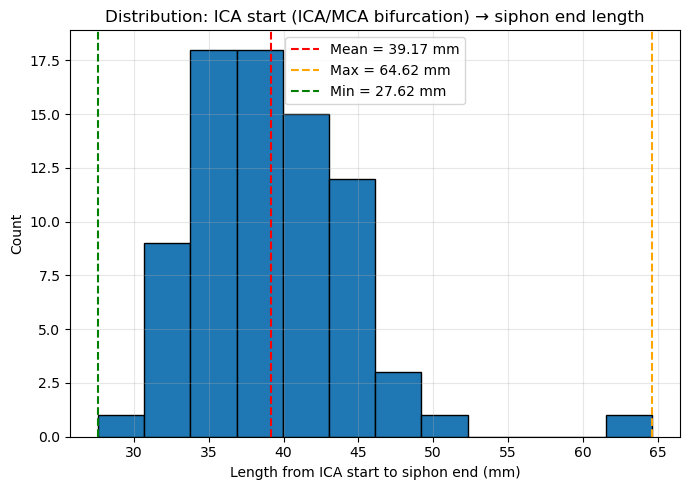

In [24]:
import os
import re
import numpy as np
import pandas as pd
import pyvista as pv
import matplotlib.pyplot as plt

# === 路径 ===
siphon_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\7_Centerline_Siphon"
full_dir   = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\2_Original(from feng)"

# 解析 siphon 文件名：期望 BG0001_L_siphon.vtk 或 BG0001_R_siphon.vtk / BG0001_ICA_L_siphon.vtk 等
sid_pattern = re.compile(r'^(?P<id>[^_]+)_(?:ICA_)?(?P<side>[LR])_siphon\.vtk$', re.IGNORECASE)

def infer_full_candidates(case_id: str, side: str):
    """
    返回完整中心线候选文件名（两种）：标准名 和 缺点号名
    e.g. BG0004 + L -> ['BG0004_ICA_L.vtk', 'BG0004_ICA_Lvtk']
    """
    std = f"{case_id}_ICA_{side}.vtk"
    nodot = f"{case_id}_ICA_{side}vtk"   # 兼容 “Lvtk/Rvtk” 命名
    return [std, nodot]

def read_polyline_and_cumlen(vtk_path: str):
    """读取 VTK 折线点并计算累计弧长（假设点已按路径顺序排列）"""
    mesh = pv.read(vtk_path)
    pts = np.asarray(mesh.points, dtype=float)
    if pts.shape[0] < 2:
        return pts, np.array([0.0])
    seg = np.linalg.norm(np.diff(pts, axis=0), axis=1)
    cum = np.insert(np.cumsum(seg), 0, 0.0)
    return pts, cum

def nearest_index(points: np.ndarray, target: np.ndarray) -> int:
    """返回 target 在 points 中的最近点索引"""
    d2 = np.sum((points - target) ** 2, axis=1)
    return int(np.argmin(d2))

records = []

# === 遍历 siphon ===
for fname in os.listdir(siphon_dir):
    if not fname.lower().endswith(".vtk") or "siphon" not in fname.lower():
        continue
    m = sid_pattern.match(fname)
    if not m:
        print(f"⚠️ 跳过无法解析的文件名：{fname}")
        continue

    case_id = m.group("id")
    side    = m.group("side").upper()
    siphon_path = os.path.join(siphon_dir, fname)

    # siphon 末点坐标
    siphon_mesh = pv.read(siphon_path)
    if siphon_mesh.n_points == 0:
        print(f"⚠️ 空数据：{fname}")
        continue
    siphon_end = np.asarray(siphon_mesh.points[-1], dtype=float)

    # 寻找完整中心线文件（两种候选名）
    candidates = infer_full_candidates(case_id, side)
    full_path = None
    for cand in candidates:
        p = os.path.join(full_dir, cand)
        if os.path.exists(p):
            full_path = p
            break

    if full_path is None:
        print(f"❌ 未找到完整中心线：候选 {candidates}")
        continue

    # 读取完整中心线并计算长度
    full_pts, full_cum = read_polyline_and_cumlen(full_path)
    idx = nearest_index(full_pts, siphon_end)
    length_to_end = float(full_cum[idx])

    records.append({
        "case_id": case_id,
        "side": side,
        "siphon_file": fname,
        "full_file": os.path.basename(full_path),
        "nearest_index": idx,
        "length_mm": length_to_end
    })

# === 汇总结果 ===
df = pd.DataFrame(records)
if df.empty:
    print("No matching results found. Please check file names or directories.")
else:
    df = df.sort_values(["case_id", "side"]).reset_index(drop=True)

    # === Statistics ===
    vals = df["length_mm"].values
    mean_len = float(np.mean(vals))
    max_len  = float(np.max(vals))
    min_len  = float(np.min(vals))

    print(f"Samples: {len(vals)}")
    print(f"Mean length: {mean_len:.2f} mm")
    print(f"Max length: {max_len:.2f} mm")
    print(f"Min length: {min_len:.2f} mm")

    # === Visualization ===
    plt.figure(figsize=(7,5))
    plt.hist(vals, bins=12, edgecolor="black")
    plt.axvline(mean_len, color="red", linestyle="--", label=f"Mean = {mean_len:.2f} mm")
    plt.axvline(max_len, color="orange", linestyle="--", label=f"Max = {max_len:.2f} mm")
    plt.axvline(min_len, color="green", linestyle="--", label=f"Min = {min_len:.2f} mm")
    plt.xlabel("Length from ICA start to siphon end (mm)")
    plt.ylabel("Count")
    plt.title("Distribution: ICA start (ICA/MCA bifurcation) → siphon end length")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()




In [1]:
import os
import re
import numpy as np
import pyvista as pv
import pandas as pd

# === 路径 ===
siphon_dir = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\7_Centerline_Siphon"
full_dir   = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\2_Original(from feng)"
out_dir    = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\10_siphon(MCA_ICA)"

os.makedirs(out_dir, exist_ok=True)

# === 文件名匹配 ===
sid_pattern = re.compile(r'^(?P<id>[^_]+)_(?:ICA_)?(?P<side>[LR])_siphon\.vtk$', re.IGNORECASE)

def infer_full_candidates(case_id: str, side: str):
    """返回完整中心线候选文件名"""
    std = f"{case_id}_ICA_{side}.vtk"
    nodot = f"{case_id}_ICA_{side}vtk"
    return [std, nodot]

def read_polyline_and_cumlen(vtk_path: str):
    """读取VTK折线点并计算累计弧长"""
    mesh = pv.read(vtk_path)
    pts = np.asarray(mesh.points, dtype=float)
    if pts.shape[0] < 2:
        return pts, np.array([0.0])
    seg = np.linalg.norm(np.diff(pts, axis=0), axis=1)
    cum = np.insert(np.cumsum(seg), 0, 0.0)
    return pts, cum

def nearest_index(points: np.ndarray, target: np.ndarray) -> int:
    """返回 target 在 points 中的最近点索引"""
    d2 = np.sum((points - target) ** 2, axis=1)
    return int(np.argmin(d2))

records = []

# === 遍历siphon ===
for fname in os.listdir(siphon_dir):
    if not fname.lower().endswith(".vtk") or "siphon" not in fname.lower():
        continue
    m = sid_pattern.match(fname)
    if not m:
        print(f"⚠️ 跳过无法解析的文件名：{fname}")
        continue

    case_id = m.group("id")
    side = m.group("side").upper()
    siphon_path = os.path.join(siphon_dir, fname)

    # 读取 siphon 末点
    siphon_mesh = pv.read(siphon_path)
    if siphon_mesh.n_points == 0:
        print(f"⚠️ 空数据：{fname}")
        continue
    siphon_end = np.asarray(siphon_mesh.points[-1], dtype=float)

    # 找到完整中心线
    full_path = None
    for cand in infer_full_candidates(case_id, side):
        p = os.path.join(full_dir, cand)
        if os.path.exists(p):
            full_path = p
            break
    if full_path is None:
        print(f"❌ 未找到完整中心线：{case_id}_{side}")
        continue

    # 读取完整中心线
    full_mesh = pv.read(full_path)
    full_pts = np.asarray(full_mesh.points, dtype=float)
    full_cum = np.insert(np.cumsum(np.linalg.norm(np.diff(full_pts, axis=0), axis=1)), 0, 0.0)

    # 计算与siphon末点最近点索引
    idx = nearest_index(full_pts, siphon_end)
    length_to_end = float(full_cum[idx])

    # === 截取从起点到 siphon 末端的部分 ===
    sub_pts = full_pts[:idx+1]
    sub_line = pv.PolyData(sub_pts)
    # 生成线单元
    cells = np.hstack([[len(sub_pts)] + list(range(len(sub_pts)))])
    sub_line.lines = cells

    out_name = f"{case_id}_{side}_MCA-ICA.vtk"
    out_path = os.path.join(out_dir, out_name)
    sub_line.save(out_path)
    print(f"✅ 已保存: {out_name} ({len(sub_pts)} pts, {length_to_end:.2f} mm)")

    records.append({
        "case_id": case_id,
        "side": side,
        "length_mm": length_to_end,
        "points": len(sub_pts)
    })

# === 结果统计 ===
df = pd.DataFrame(records)
if not df.empty:
    print("\n=== Summary ===")
    print(df.head())
    print(f"Total: {len(df)}")
    print(f"Mean length: {df['length_mm'].mean():.2f} mm")
else:
    print("No valid results found.")


✅ 已保存: BG0001_L_MCA-ICA.vtk (60 pts, 37.62 mm)
✅ 已保存: BG0001_R_MCA-ICA.vtk (62 pts, 34.84 mm)
✅ 已保存: BG0004_L_MCA-ICA.vtk (67 pts, 44.06 mm)
✅ 已保存: BG0004_R_MCA-ICA.vtk (65 pts, 40.19 mm)
✅ 已保存: BG0006_L_MCA-ICA.vtk (65 pts, 44.54 mm)
✅ 已保存: BG0006_R_MCA-ICA.vtk (67 pts, 45.68 mm)
✅ 已保存: BG0007_L_MCA-ICA.vtk (64 pts, 33.99 mm)
✅ 已保存: BG0007_R_MCA-ICA.vtk (68 pts, 38.21 mm)
✅ 已保存: BG0008_L_MCA-ICA.vtk (65 pts, 33.47 mm)
✅ 已保存: BG0008_R_MCA-ICA.vtk (65 pts, 31.64 mm)
✅ 已保存: BG0009_L_MCA-ICA.vtk (69 pts, 45.71 mm)
✅ 已保存: BG0009_R_MCA-ICA.vtk (64 pts, 38.14 mm)
✅ 已保存: BG0010_L_MCA-ICA.vtk (67 pts, 48.27 mm)
✅ 已保存: BG0010_R_MCA-ICA.vtk (67 pts, 38.96 mm)
✅ 已保存: BG0011_L_MCA-ICA.vtk (68 pts, 50.74 mm)
✅ 已保存: BG0011_R_MCA-ICA.vtk (68 pts, 48.82 mm)
✅ 已保存: BG0012_L_MCA-ICA.vtk (62 pts, 34.22 mm)
✅ 已保存: BG0012_R_MCA-ICA.vtk (64 pts, 33.92 mm)
✅ 已保存: BG0017_L_MCA-ICA.vtk (71 pts, 44.82 mm)
✅ 已保存: BG0017_R_MCA-ICA.vtk (73 pts, 42.74 mm)
✅ 已保存: BG0018_L_MCA-ICA.vtk (71 pts, 45.51 mm)
✅ 已保存: BG0018

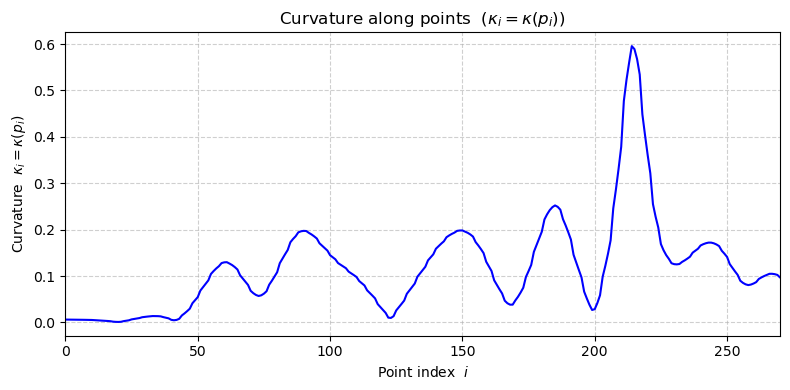

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_ply_with_curvature_torsion(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    header_end_idx = next(i for i, line in enumerate(lines) if 'end_header' in line)
    vertex_count = 0
    for line in lines:
        if line.startswith("element vertex"):
            vertex_count = int(line.split()[-1])
            break

    vertex_lines = lines[header_end_idx + 1 : header_end_idx + 1 + vertex_count]
    data = [list(map(float, line.strip().split())) for line in vertex_lines]
    df = pd.DataFrame(data, columns=["x", "y", "z", "label", "attribute", "radius", "curvature", "torsion"])
    return df

# === 选择单条中心线文件 ===
filepath = r"D:\github\Phd_summary\1_Data\1_Brava\1_Centerline\6_Centerline(V-modeler)\BG0001_L.ply"

# === 读取数据 ===
df = load_ply_with_curvature_torsion(filepath)

# === 曲率反转（左右翻转）===
df["curvature_flipped"] = df["curvature"].iloc[::-1].reset_index(drop=True)

# === 绘制曲率 ===
plt.figure(figsize=(8, 4))
plt.plot(df.index, df["curvature_flipped"], color='blue', linewidth=1.5)

plt.title(r"Curvature along points  ($\kappa_i = \kappa(p_i)$)", fontsize=12)
plt.xlabel(r"Point index  $i$")
plt.ylabel(r"Curvature  $\kappa_i = \kappa(p_i)$")
plt.xlim(0, 270)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
